In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
init_df = pd.read_csv('../datasets/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'age_group'])
init_df.sample(15)

,text,age_group,n_words,tokenized
77309,"Hey Frank, go here AP Central's English Langua...",<18,173,"hey frank , go here ap central 's english lang..."
71088,Ben: well my science project was originally gi...,<18,51,ben : well my science project was originally g...
285938,"exama are not cool. in actuality, it is a meas...",<18,101,"exama are not cool . in actuality , it is a me..."
395143,I just finished Susan Cheever's bio of Bill Wi...,>35,437,i just finished susan cheever 's bio of bill w...
456015,Thank you for visiting my site. I am writing ...,<18,206,thank you for visiting my site . i am writin...
413113,It has been an eventful couple of weeks with a...,18-24,406,it has been an eventful couple of weeks with a...
349627,Shit!!! The deadline for the proposal is this ...,<18,46,shit ! ! ! the deadline for the proposal is th...
295381,Jamba Juice Orange A-Peel w/burner boost and v...,18-24,39,jamba juice orange a - peel w / burner boost a...
317902,"Now, here's the part where I write really witt...",18-24,463,"now , here 's the part where i write really wi..."
239930,Well in the beginning of the day nothing reall...,<18,145,well in the beginning of the day nothing reall...


In [3]:
init_df.isnull().sum()

text         0
age_group    0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by age group
df = init_df.groupby('age_group', group_keys=False).apply(lambda x: x.sample(frac=.05))
df.shape

(31779, 4)

In [5]:
df['age_group'].replace({'<18': np.nan, '18-24': '<35', '25-34': '<35'}, inplace=True)
df['age_group'].value_counts()

<35    16886
>35     3987
Name: age_group, dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

text         0
age_group    0
n_words      0
tokenized    0
dtype: int64

In [10]:
enc = LabelEncoder()
enc.fit(df['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['age_group'] = enc.transform(df['age_group'])
encoded_labels

{'<35': 0, '>35': 1}

## On initial data

In [11]:
X = df[['text']]
y = df[['age_group']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16698, 1), (4175, 1), (16698, 1), (4175, 1))

In [12]:
ch_2grams_cv = TfidfVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000, stop_words=None)
ch_3grams_cv = TfidfVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000, stop_words=None)
wd_2grams_cv = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=1000, stop_words=None)
wd_3grams_cv = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=None)
scl = MinMaxScaler()

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
    # ('scaler', scl, 'n_words'),
], remainder='drop', n_jobs=-1)

svm = SVC(kernel='linear')

pipe = make_pipeline(ct, svm)

In [13]:
param_grid = {
    'svc__C': [0.1],
    'svc__gamma': [0.0001]
}

In [14]:
gs = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\github\clips-internship\.venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'svc__C': 0.1, 'svc__gamma': 0.0001}


In [15]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      3378
           1       1.00      0.01      0.01       797

    accuracy                           0.81      4175
   macro avg       0.90      0.50      0.45      4175
weighted avg       0.85      0.81      0.73      4175



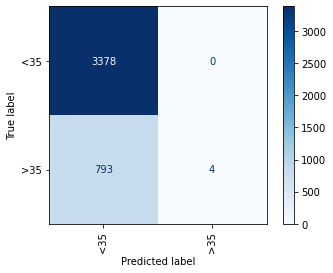

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');